# Fake News Detector
**Caitlin Petro** @ UNCC / ITCS-5156

## Prepare Environment

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Imports

In [ ]:
# install
!pip install pytorch-pretrained-bert pytorch-nlp
!pip install keras_preprocessing

# Preprocessing
import gc
import os 
import warnings 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# BERT
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange

# check GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'Tesla T4'

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
col_names = ['ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Speaker_Job_Title', 
                    'State_Info', 'Party_Affiliation', 'Barely_True_Count', 'False_Count', 
                    'Half_True_Count', 'Mostly_True_Count', 'Pants_On_Fire_Count', 'Context']

In [ ]:
def load_news_data(n=col_names, s=r'\t', e='python'):
    
    pth = '/content/gdrive/My Drive/ITCS-5156/fake-news-detector/liar_dataset/'
    liar_data = [pth+'train.tsv', pth+'test.tsv', pth+'valid.tsv']
    
    for data in liar_data:
        if not os.path.exists(data):
            warnings.warn("Data not detected in your local path!")  
    
    trn = pd.read_csv(liar_data[0], sep=s, names=n, engine=e)
    tst = pd.read_csv(liar_data[1], sep=s, names=n, engine=e)
    vld = pd.read_csv(liar_data[2], sep=s, names=n, engine=e)
    
    print('Liar dataset has been loaded successfully')
    return trn, tst, vld

In [ ]:
df_train, df_test, df_valid = load_news_data()

Liar dataset has been loaded successfully


# Data Preprocessing Methods

In [ ]:
# Replace NaNs
def replace_nans(df):
    df = df.replace(np.nan, 'none')
    return df

In [ ]:
# Binarze 'Label' column
def binarize_labels(df):
    true_labels = ['true', 'mostly-true']
    false_labels = ['half-true', 'barely-true', 'pants-fire']
    
    df['Label'] = df['Label'].replace(true_labels, 'true')
    df['Label'] = df['Label'].replace(false_labels, 'false')
    return df

In [ ]:
# Encode 'Label' column
def encode_label(df, col='Label', cat_col='Label_Cat'):
    labelencoder = LabelEncoder()
    df[cat_col] = labelencoder.fit_transform(df[col])
    return df

In [ ]:
# Drop columns
def drop_columns(df):
    cols_to_drop = ['ID', 'Label', 'Barely_True_Count', 'False_Count', 
                'Half_True_Count', 'Mostly_True_Count', 'Pants_On_Fire_Count']
    df = df.drop(labels=cols_to_drop, axis=1)
    return df

In [ ]:
# Convert strings in columns to lower-case
def to_lowercase(df):
    cols = ['Statement', 'Subject', 'Speaker', 'Speaker_Job_Title', 'State_Info', 'Party_Affiliation', 'Context']
    for col in cols:
        df[col] = df[col].str.lower()
    return df

# Apply Data Preprocessing

In [ ]:
def apply_preprocessing(df):
    df = (df.pipe(replace_nans)
            .pipe(binarize_labels)
            .pipe(encode_label)
            .pipe(drop_columns)
            .pipe(to_lowercase))
    return df

df_train = apply_preprocessing(df_train)
print("df_train successfully preprocessed")

df_test = apply_preprocessing(df_test)
print("df_test successfully preprocessed")

df_valid = apply_preprocessing(df_valid)
print("df_valid successfully preprocessed")

df_train successfully preprocessed
df_test successfully preprocessed
df_valid successfully preprocessed


# Visualize Label Distribution

Training set label distribution
Fake = 6620, True = 3649


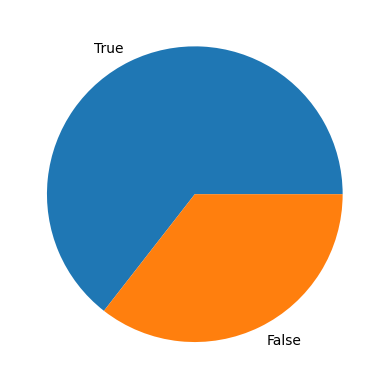

Testing set label distribution
Fake = 823, True = 460


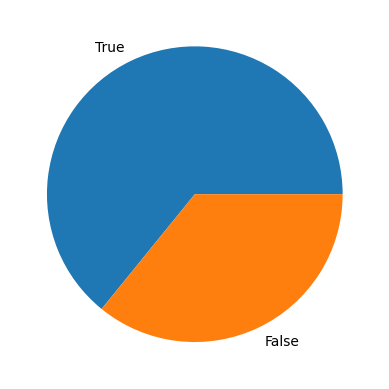

Validation set label distribution
Fake = 864, True = 420


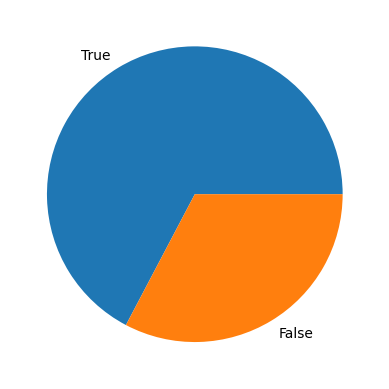

In [ ]:
def distribute_labels(df):       
    df_label_cnts = df['Label_Cat'].value_counts()
    print('Fake = ' + str(df_label_cnts[0]) + ", True = " + str(df_label_cnts[1]))
    plt.pie(df_label_cnts, labels=['True', 'False'])
    plt.show()
    
print("Training set label distribution")
distribute_labels(df_train)

print("Testing set label distribution")
distribute_labels(df_test)

print("Validation set label distribution")
distribute_labels(df_valid)

In [ ]:
df_train.head(5)

,Statement,Subject,Speaker,Speaker_Job_Title,State_Info,Party_Affiliation,Context,Label_Cat
0,says the annies list political group supports ...,abortion,dwayne-bohac,state representative,texas,republican,a mailer,0
1,when did the decline of coal start? it started...,"energy,history,job-accomplishments",scott-surovell,state delegate,virginia,democrat,a floor speech.,0
2,"hillary clinton agrees with john mccain ""by vo...",foreign-policy,barack-obama,president,illinois,democrat,denver,1
3,health care reform legislation is likely to ma...,health-care,blog-posting,none,none,none,a news release,0
4,the economic turnaround started at the end of ...,"economy,jobs",charlie-crist,none,florida,democrat,an interview on cnn,0


# Prepare Data for BERT
Resource: https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

In [ ]:
def get_labels(df):
    labels = df['Label_Cat']
    return labels

In [ ]:
# Add special tokens to mark statements
def tokenize(df):
    statements = df['Statement']
    labels = df['Label_Cat']
    tokens = ["[CLS] " + state + " [SEP]" for state in statements]
    print(tokens[0])

    # Tokenize with BERT tokenizer 
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    tokenized_texts = [tokenizer.tokenize(s) for s in statements]
    print(tokenized_texts[0])
    
    # Maximum sequence length
    MAX_LEN = 400

    # Pad input tokens
    inputs = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                              maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # BERT tokenizer converts tokens to their index numbers in the BERT vocabulary
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    
    return inputs

In [ ]:
def mask(input_ids):
    # Define BERT attention mask
    attention_mask = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_mask.append(seq_mask)
        
    return attention_mask

In [ ]:
train_labels = get_labels(df_train)
train_inputs = tokenize(df_train)
train_masks = mask(train_inputs)

test_labels = get_labels(df_test)
test_inputs = tokenize(df_test)
test_masks = mask(test_inputs)

valid_labels = get_labels(df_valid)
valid_inputs = tokenize(df_valid)
valid_masks = mask(valid_inputs)

print(train_masks[0])
print(test_masks[0])
print(valid_masks[0])

[CLS] says the annies list political group supports third-trimester abortions on demand. [SEP]


100%|██████████| 231508/231508 [00:00<00:00, 348586.14B/s]


['says', 'the', 'annie', '##s', 'list', 'political', 'group', 'supports', 'third', '-', 'trim', '##ester', 'abortion', '##s', 'on', 'demand', '.']
[CLS] building a wall on the u.s.-mexico border will take literally years. [SEP]
['building', 'a', 'wall', 'on', 'the', 'u', '.', 's', '.', '-', 'mexico', 'border', 'will', 'take', 'literally', 'years', '.']
[CLS] we have less americans working now than in the 70s. [SEP]
['we', 'have', 'less', 'americans', 'working', 'now', 'than', 'in', 'the', '70s', '.']
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

## Tensors and Iterators

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
valid_inputs = torch.tensor(valid_inputs)
train_labels = torch.tensor(train_labels)
valid_labels = torch.tensor(valid_labels)
train_masks = torch.tensor(train_masks)
valid_masks = torch.tensor(valid_masks)

# Select a batch size for training. 
batch_size = 16

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

## Fine-tune BERT Model

In [ ]:
from pytorch_pretrained_bert import BertForSequenceClassification

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(train_labels))
model.cuda()

100%|██████████| 407873900/407873900 [00:33<00:00, 12063916.66B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.8435699367820289


Epoch:  25%|██▌       | 1/4 [15:11<45:35, 911.67s/it]

Validation Accuracy: 0.6712962962962963
Train loss: 0.6120284619361069


Epoch:  50%|█████     | 2/4 [30:18<30:17, 908.62s/it]

Validation Accuracy: 0.6751543209876543
Train loss: 0.5183586625388107


Epoch:  75%|███████▌  | 3/4 [45:23<15:06, 906.95s/it]

Validation Accuracy: 0.6782407407407407
Train loss: 0.3371149727442183


Epoch: 100%|██████████| 4/4 [1:00:29<00:00, 907.31s/it]

Validation Accuracy: 0.6566358024691358


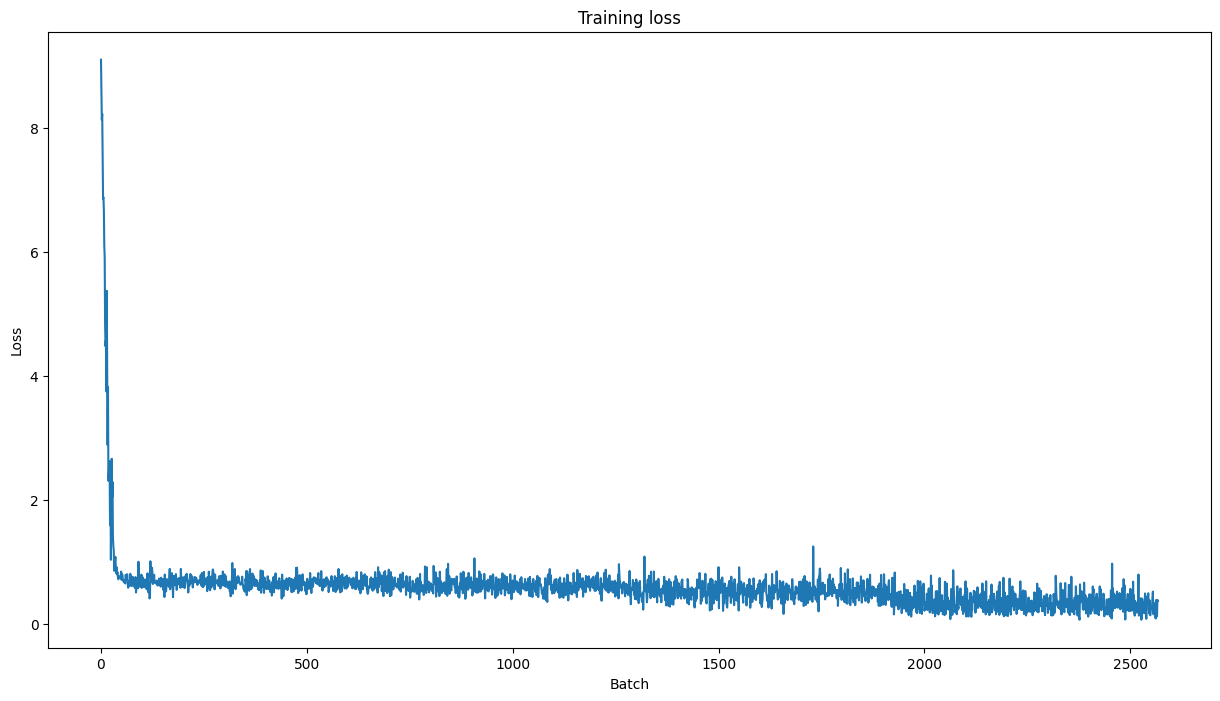

In [ ]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in valid_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()